In [2]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import gym
import torch

from DQN import DQN
from ReplayMemory import ReplayMemory, Transition
from utils import select_action, plot_durations



def train(policy_net, optimizer, memory, batch_size, gamma, device):
    if len(memory) < batch_size:
        return
    
    batch = Transition(*zip(*memory.sample(batch_size)))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    ).to(device)

    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1)[0].detach()
      
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
    optimizer.step()


Complete


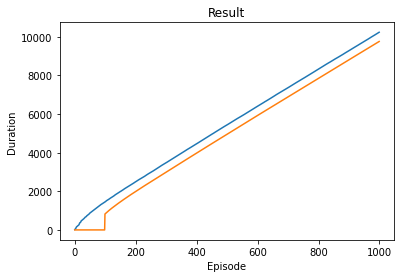

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
env = gym.make("CartPole-v1")
  
plt.ion()

is_ipython = "inline" in matplotlib.get_backend()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 128
gamma = 0.99
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1000
tau = 0.005
lr = 1e-4
number_of_episodes = 1000
number_of_steps = 100
replay_memory_size = 10000
number_of_actions = env.action_space.n

state = env.reset()
number_of_observations = len(state)

policy_net = DQN(number_of_observations, number_of_actions).to(device)
target_net = DQN(number_of_observations, number_of_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr, amsgrad=True)
memory = ReplayMemory(replay_memory_size)

episode_durations = []

rewards = []

steps_done = 0



for episode in range(number_of_episodes):
    state = env.reset()
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    cumulative_reward = 0

    for t in count():
        action, steps_done = select_action(
            env,
            policy_net,
            device,
            state,
            steps_done,
            epsilon_start,
            epsilon_end,
            epsilon_decay,
        )

        next_state, reward, terminated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        cumulative_reward += reward
        

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                next_state, dtype=torch.float32, device=device
            ).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        train(policy_net, optimizer, memory, batch_size, gamma, device)

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
        target_net.load_state_dict(target_net_state_dict)


        if terminated:
            episode_durations.append(steps_done + 1)
            rewards.append(cumulative_reward)
            plot_durations(episode_durations, is_ipython=is_ipython)
            break

print("Complete")
plot_durations(episode_durations, show_results=True, is_ipython=is_ipython)
plt.ioff()
plt.show()
plt.savefig("./dqn-cartpole.png")
